<a href="https://colab.research.google.com/github/smlra-kjsce/Introduction-to-VAEs-and-GANs/blob/master/Dense_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variational Autoencoders

In [0]:
# make sure to enable GPU acceleration! == Done
device = 'cuda'

#!pip3 install torch torchvision
!pip install torchviz

#Import Libraries


from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import pi

In [0]:
args={}
kwargs={}
args['batch_size']=1000
args['test_batch_size']=1000
args['epochs']= 42 #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=0.01 #Learning rate is how fast it will decend. 
args['momentum']=0.5 #SGD momentum (default: 0.5) Momentum is a moving average of our gradients (helps to keep direction).

args['seed']=1 #random seed
args['log_interval']=10
args['cuda']=True
args['latent_dim']=2

In [0]:
#load the data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor()
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

data = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

In [0]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
    
    def forward(self, x):
        self.x = x.view(-1,784)
        self.after_fc1 = F.relu(self.fc1(self.x))
        self.after_fc2 = F.relu(self.fc2(self.after_fc1))
        
        self.after_mu = self.fc31(self.after_fc2)
        self.after_var = self.fc32(self.after_fc2)
        self.z = self.sampling(self.after_mu, self.after_var)
        
        self.after_fc4 = F.relu(self.fc4(self.z))
        self.after_fc5 = F.relu(self.fc5(self.after_fc4))
        self.after_fc6 = self.fc6(self.after_fc5)
        
        return F.sigmoid(self.after_fc6), self.after_mu, self.after_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=args['latent_dim'])
if torch.cuda.is_available():
    vae.cuda()

In [0]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [0]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [0]:
for epoch in range(args['epochs']):
  train(epoch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 543.717562
====> Epoch: 0 Average loss: 238.7989
Train Epoch: 1 [0/60000 (0%)]	Loss: 195.782141
====> Epoch: 1 Average loss: 184.4171
Train Epoch: 2 [0/60000 (0%)]	Loss: 177.414062
====> Epoch: 2 Average loss: 173.8885
Train Epoch: 3 [0/60000 (0%)]	Loss: 170.528578
====> Epoch: 3 Average loss: 168.5926
Train Epoch: 4 [0/60000 (0%)]	Loss: 165.286937
====> Epoch: 4 Average loss: 165.1644
Train Epoch: 5 [0/60000 (0%)]	Loss: 164.751812
====> Epoch: 5 Average loss: 162.5991
Train Epoch: 6 [0/60000 (0%)]	Loss: 160.714672
====> Epoch: 6 Average loss: 160.6124
Train Epoch: 7 [0/60000 (0%)]	Loss: 160.050000
====> Epoch: 7 Average loss: 158.8474
Train Epoch: 8 [0/60000 (0%)]	Loss: 159.056422
====> Epoch: 8 Average loss: 157.4453
Train Epoch: 9 [0/60000 (0%)]	Loss: 154.777531
====> Epoch: 9 Average loss: 156.0925
Train Epoch: 10 [0/60000 (0%)]	Loss: 156.962016
====> Epoch: 10 Average loss: 154.8308
Train Epoch: 11 [0/60000 (0%)]	Loss: 152.563375
====> Epoch: 11

In [0]:
# Evaluating an Example
e = 1
vae.train()
example = data.data[e]

if args['cuda']:
    vae.cuda()
    example = example.cuda()

example = Variable(example,volatile=True).float()
print(vae(example))

plt.matshow(data.data[e])
plt.colorbar()

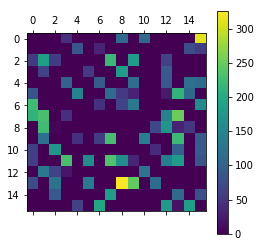

In [0]:
plt.matshow(vae.after_fc2.cpu().detach().numpy().reshape(16,16))
plt.colorbar()
plt.show()

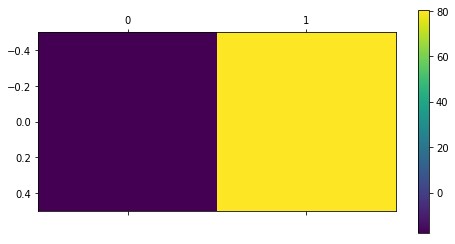

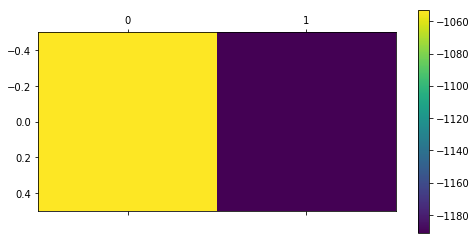

In [0]:
img = plt.matshow(vae.after_mu.cpu().detach().numpy())
plt.colorbar()
plt.show()

plt.matshow(vae.after_var.cpu().detach().numpy())
plt.colorbar()
plt.show()

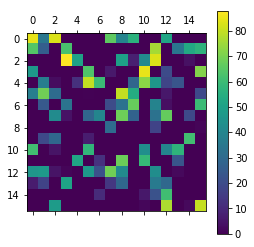

In [0]:
plt.matshow(vae.after_fc4.cpu().detach().numpy().reshape(16,16))
plt.colorbar()
plt.show()

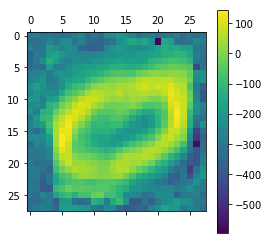

In [0]:
plt.matshow(vae.after_fc6.cpu().detach().numpy().reshape(28,28))
plt.colorbar()
plt.show()